In [1]:
import os
import dotenv

dotenv.load_dotenv(override=True)

True

In [2]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("llama3-8b-8192", model_provider="groq")

In [3]:
from langgraph.graph import START, StateGraph

In [4]:
from typing import Literal, TypedDict
from langgraph.graph import StateGraph

# Типы для состояния и возвращаемых значений
class State(TypedDict):
    genre: Literal["comedy", "scifi", None]
    period: Literal["new", "classic", None]
    recommendation: str | None

# --- Узлы ---
def ask_comedy_period(state: State) -> State:
    return {"period": "new"}  # Фиксируем "new" для примера

def recommend_top_new_comedy(state: State) -> State:
    state["recommendation"] = "Омерзительная восьмёрка (2023)"
    return state

def recommend_classic_comedy(state: State) -> State:
    state["recommendation"] = "Назад в будущее (1985)"
    return state

def use_watch_history_for_scifi(state: State) -> State:
    state["recommendation"] = "Дюна (2021)"
    return state

def format_result(state: State) -> State:
    print(f"Рекомендация: {state['recommendation']}")
    return state



In [5]:
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage

class GenreOutput(TypedDict):
    genre: Literal["comedy", "scifi", None]
    finished: bool
    next_question: str | None

def ask_genre(state: State) -> State:
    prompt = '''
        Ты - помощник по подбору фильмов.
        Определи по запросу, фильм какого жанра предпочитает пользователь.
        Если недостаточно информации, то задай ему уточняющий/наводящий вопрос.
        Можно задать несколько вопросов и привести примеры.
        
        Ответ верни в формате json: {{"genre": "жанр", "finished": true/false, "next_question": "уточняющий вопрос/пример"}}
        Если жанр определен, поле "finished" должно быть true.
        Если жанр не определен, поле "finished" должно быть false.
        Если жанр отличается от "comedy" или "scifi", верни "comedy".
        Поле "next_question" обязательно, если поле "finished" равно false.
        В поле "next_question" я ожидаю уточняющий вопрос/пример для пользователя, чтобы помочь ему определиться с жанром фильма.
        Абсолютно всегда, при любых обстоятельствах возвращай json в формате, указанном выше.
        '''

    sys_message = SystemMessage(content=prompt)
    got_genre = False
    sturctued_llm = llm.with_structured_output(GenreOutput)
    question = 'Что ты хочешь посмотреть?'

    while not got_genre:
        print("Запрос жанра...")
        user_in = input(question)
        response = sturctued_llm.invoke([
            sys_message,
            HumanMessage(content=user_in)
        ])
        print(f"Ответ от модели: {response}")
        got_genre = response["finished"]

        if not got_genre:
            question = response["next_question"]

    
    return {"genre": "comedy"}  # Для примера фиксируем "comedy"


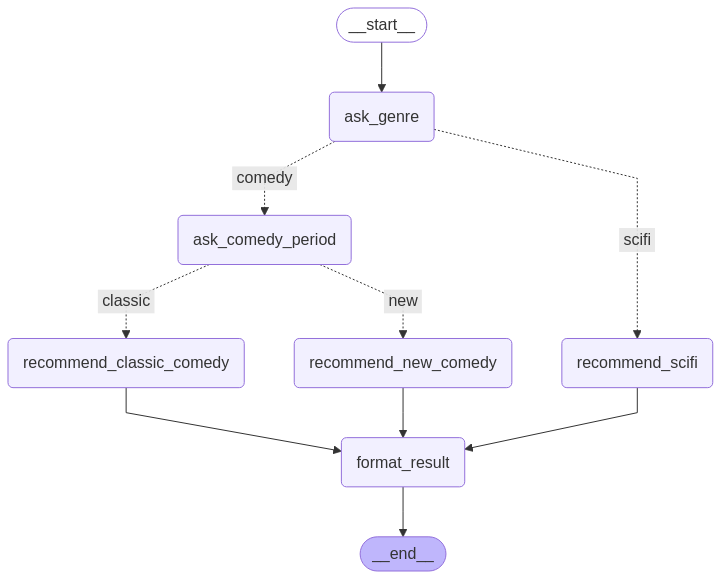

In [6]:
# --- Граф ---
builder = StateGraph(State)

# Добавляем узлы
builder.add_node("ask_genre", ask_genre)
builder.add_node("ask_comedy_period", ask_comedy_period)
builder.add_node("recommend_new_comedy", recommend_top_new_comedy)
builder.add_node("recommend_classic_comedy", recommend_classic_comedy)
builder.add_node("recommend_scifi", use_watch_history_for_scifi)
builder.add_node("format_result", format_result)

# Стартовое ребро
builder.set_entry_point("ask_genre")

# Условные переходы из "ask_genre"
def route_genre(state: State) -> Literal["comedy", "scifi"]:
    return state["genre"]  # "comedy" или "scifi"

builder.add_conditional_edges(
    "ask_genre",
    route_genre,  # Функция-роутер (возвращает следующую ноду)
    {
        "comedy": "ask_comedy_period",
        "scifi": "recommend_scifi",
    }
)

# Условные переходы из "ask_comedy_period"
def route_period(state: State) -> Literal["new", "classic"]:
    return state["period"]

builder.add_conditional_edges(
    "ask_comedy_period",
    route_period,
    {
        "new": "recommend_new_comedy",
        "classic": "recommend_classic_comedy",
    }
)

# Фиксированные рёбра к результату
builder.add_edge("recommend_new_comedy", "format_result")
builder.add_edge("recommend_classic_comedy", "format_result")
builder.add_edge("recommend_scifi", "format_result")

# Финальный узел
builder.set_finish_point("format_result")

# Компилируем граф
graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
result = graph.invoke({"genre": None, "period": None})

Запрос жанра...


Что ты хочешь посмотреть? Я не знаю


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '/tool-use>\n{\n  "tool_calls": [\n    {\n      "id": "pending",\n      "type": "function",\n      "function": {\n        "name": "GenreOutput"\n      },\n      "parameters": {\n        "finished": false,\n        "genre": null,\n        "next_question": "Вам понравился фильм? Если да, то какой жанр?"\n      }\n    }\n  ]\n}\n</tool-use>'}}

In [8]:
# --- Узлы ---
def ask_genre(state: State) -> State:
    prompt = '''
        Ты - помощник по подбору фильмов.
        Определи по запросу, фильм какого жанра предпочитает пользователь.
        Если недостаточно информации, то задай ему уточняющий/наводящий вопрос.
        
        Ответ верни в формате json: {{"genre": "жанр", "finished": true/false, "next_question": "уточняющий вопрос"}}
        Если жанр определен, поле "finished" должно быть true.
        Если жанр не определен, поле "finished" должно быть false.
        Поле "next_question" обязательно, если поле "finished" равно false.
        '''

    sys_message = SystemMessage(content=prompt)
    sturctued_llm = llm.with_structured_output(GenreOutput)
    user_in = input("Что ты хочешь посмотреть? ")
    response = sturctued_llm.invoke([
        sys_message,
        HumanMessage(content=user_in)
    ])
    print(f"Ответ от модели: {response}")

    return {
        "genre": response.get("genre"),
        "finished": response.get("finished"),
        "next_question": response.get("next_question")
    }

def ask_for_clarification(state: State) -> State:
    question = state["next_question"]
    user_in = input(f"{question} ")
    return {"user_response": user_in}

def process_clarification(state: State) -> State:
    # Здесь можно добавить дополнительную логику для анализа ответа
    return {"genre": "comedy", "finished": True}  # Пример фиксации жанра


Построим граф иначе - с условными узлами

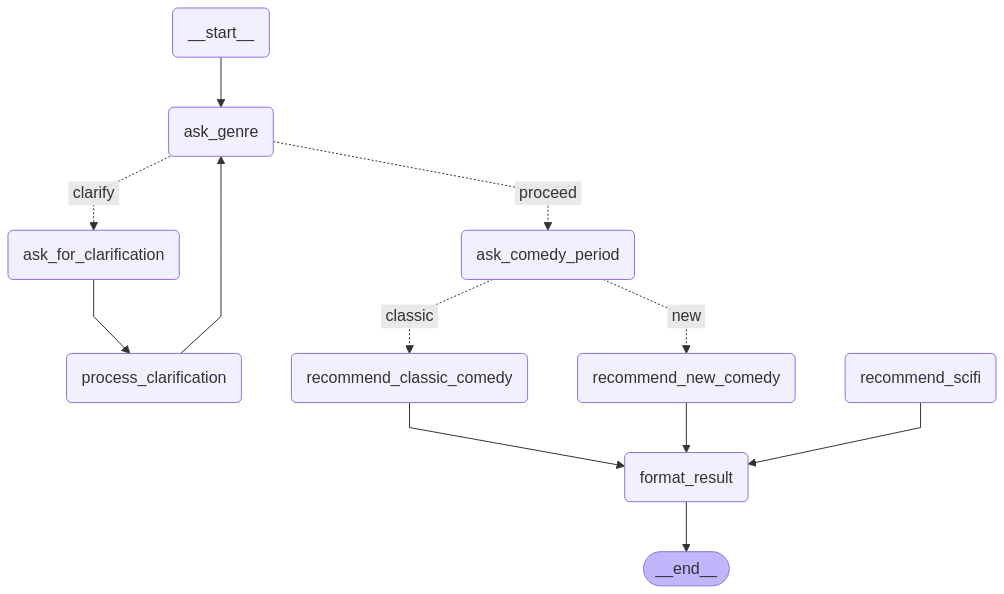

In [12]:
# --- Граф ---
class State(TypedDict):
    genre: Literal["comedy", "scifi", None]
    period: Literal["new", "classic", None]
    recommendation: str | None
    next_question: str | None  # Уточняющий вопрос для пользователя
    
builder = StateGraph(State)

# Добавляем узлы
builder.add_node("ask_genre", ask_genre)
builder.add_node("ask_for_clarification", ask_for_clarification)
builder.add_node("process_clarification", process_clarification)
builder.add_node("ask_comedy_period", lambda _: {"period": "new"})  # Фиксируем "new" для примера
builder.add_node("recommend_new_comedy", recommend_top_new_comedy)
builder.add_node("recommend_classic_comedy", recommend_classic_comedy)
builder.add_node("recommend_scifi", use_watch_history_for_scifi)
builder.add_node("format_result", format_result)

# Стартовое ребро
builder.set_entry_point("ask_genre")

# Условные переходы из "ask_genre"
def route_after_ask_genre(state: State) -> Literal["clarify", "proceed"]:
    return "proceed" if state["finished"] else "clarify"

builder.add_conditional_edges(
    "ask_genre",
    route_after_ask_genre,
    {
        "clarify": "ask_for_clarification",
        "proceed": "ask_comedy_period",
    }
)

# Переход после уточнения
builder.add_edge("ask_for_clarification", "process_clarification")
builder.add_edge("process_clarification", "ask_genre")  # Возвращаемся к определению жанра

# Условные переходы из "ask_comedy_period"
def route_period(state: State) -> Literal["new", "classic"]:
    return state["period"]

builder.add_conditional_edges(
    "ask_comedy_period",
    route_period,
    {
        "new": "recommend_new_comedy",
        "classic": "recommend_classic_comedy",
    }
)

# Фиксированные рёбра к результату
builder.add_edge("recommend_new_comedy", "format_result")
builder.add_edge("recommend_classic_comedy", "format_result")
builder.add_edge("recommend_scifi", "format_result")

# Финальный узел
builder.set_finish_point("format_result")

# Компилируем граф
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
graph.invoke(State(genre=None, period=None))

Что ты хочешь посмотреть?  Не знаю. А что есть?


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n  "tool_calls": [\n    {\n      "id": "pending",\n      "type": "function",\n      "function": {\n        "name": "GenreOutput"\n      },\n      "parameters": {\n        "genre": null,\n        "finished": false,\n        "next_question": "В каком жанре фильм предпочитает пользователь?"\n      }\n    }\n  ]\n}\n</tool-use>'}}